In [1]:
import matplotlib.pyplot as plt

from jax import config
config.update("jax_enable_x64", True)
from jax import numpy as jnp

from FABdiffME.targets.lambdac import Lambdac

## Test class `Lambdac`
- decay $\Lambda_c^+ \to p K^- \pi^+$ default model
- more information: https://compwa-org.readthedocs.io/report/021.html
- https://compwa.github.io/polarimetry/intensity.html
- class `Lambdac` loads model and extracts mass values automatically
- particle masses should correspond to
$$m_{\Lambda_c} = m_0 = 2.28646 ~ \text{GeV}\\ m_p = m_1 = 0.938272081 ~ \text{GeV}\\ m_{\pi} = m_2 = 0.13957039 ~ \text{GeV}\\ m_{K} = m_3 = 0.493677 ~ \text{GeV}$$


In [2]:
print("Loading density ...")
target = Lambdac(dim=2)
print("... done")
print("Masses:", target.m0, target.m1, target.m2, target.m3)

Loading density ...
... done
Masses: 2.28646 0.938272046 0.13957018 0.49367700000000003


### `target.get_density()` depends on

- $\sigma_1 = s_{23} = m_{K\pi}^2$, mass squared of the $K^- \pi^+$ system $\sigma_1 \in [(m_2+m_3)^2, (m_0 - m_1)^2]$, and
- $\sigma_2 = s_{13} = m_{pK}^2$, mass squared of the $p K^-$ system $\sigma_2 \in [(m_1+m_3)^2, (m_0 - m_2)^2]$

In [3]:
density = target.get_density()

### Plot Physical Region of Dalitz Plot
- compared to `pi1800` matrix element, function `is_physical` the same, except for circular permutation of indices by 2: $1 \rightarrow 2 \rightarrow 3 \rightarrow 1 ...$

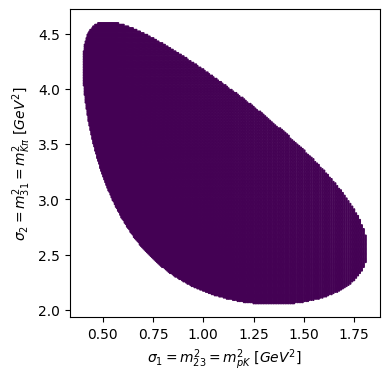

In [4]:
s23vs = jnp.linspace(target.m2 + target.m3, target.m0 - target.m1, 200)[1:-1]**2
s31vs = jnp.linspace(target.m3 + target.m1, target.m0 - target.m2, 202)[1:-1]**2
grid = jnp.dstack(jnp.meshgrid(s23vs, s31vs))
grid = grid.reshape([-1, 2])

physical_region = target.is_physical_nan(grid[:,0], grid[:,1]) # (s23, s31)

plt.figure(figsize=(4, 4))
plt.scatter(grid[:,0], grid[:,1], c=physical_region, s=.5)
plt.xlabel(r"$\sigma_1 = m_{23}^2 = m_{pK}^2 ~ [GeV^2]$")
plt.ylabel(r"$\sigma_2 = m_{31}^2 = m_{K\pi}^2 ~ [GeV^2]$");

### Plot normalized matrix element

Minimal value: 413.4227509500096 , Maximal value: 15839.049553753874


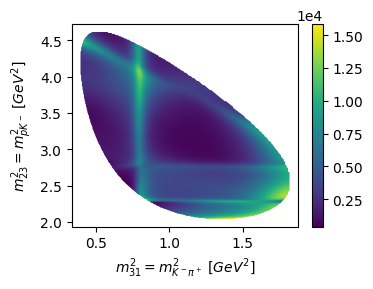

In [5]:
intensity_vals = target.get_decay_rate(grid)
print("Minimal value:", jnp.nanmin(intensity_vals), ", Maximal value:", jnp.nanmax(intensity_vals))

plt.figure(figsize=(3.75, 3))
plt.scatter(grid[:,0], grid[:,1], c=intensity_vals, s=1)
cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))
#cbar.ax.set_ylabel('Intensity')
plt.ylabel(r"$m_{23}^2 = m_{pK^-}^2 ~ [GeV^2]$")
plt.xlabel(r"$m_{31}^2 = m_{K^-\pi^+}^2 ~ [GeV^2]$")
#plt.ylabel(r"$\sigma_1 = m_{23}^2 = m_{pK}^2 ~ [GeV^2]$")
#plt.xlabel(r"$\sigma_2 = m_{31}^2 = m_{K\pi}^2 ~ [GeV^2]$")
plt.tight_layout();
#plt.savefig(f"../../plots/{target.name}/dalitz_plot.pdf")

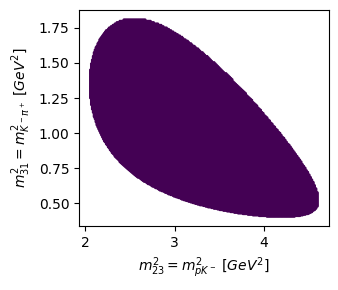

In [6]:
physical_region = target.is_physical_nan(grid[:,0], grid[:,1]) # (s23, s31)

plt.figure(figsize=(3.4, 3))
plt.scatter(grid[:,1], grid[:,0], c=physical_region.T, s=1)
plt.xlabel(r"$m_{23}^2 = m_{pK^-}^2 ~ [GeV^2]$")
plt.ylabel(r"$m_{31}^2 = m_{K^-\pi^+}^2 ~ [GeV^2]$")
plt.tight_layout();

Minimal value: 413.4227509500096 , Maximal value: 15839.049553753874


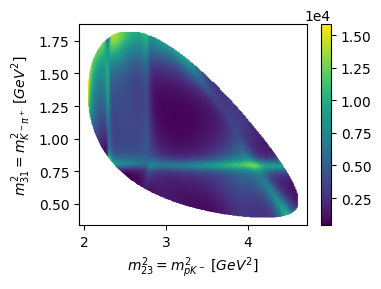

In [7]:
intensity_vals = target.get_decay_rate(grid)
print("Minimal value:", jnp.nanmin(intensity_vals), ", Maximal value:", jnp.nanmax(intensity_vals))

plt.figure(figsize=(3.75, 3))
plt.scatter(grid[:,1], grid[:,0], c=intensity_vals.T, s=1)
cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))
plt.xlabel(r"$m_{23}^2 = m_{pK^-}^2 ~ [GeV^2]$")
plt.ylabel(r"$m_{31}^2 = m_{K^-\pi^+}^2 ~ [GeV^2]$")
plt.tight_layout();

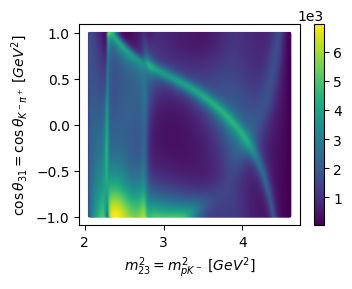

In [8]:
x = y = jnp.linspace(0., 1., 300)[1:-1]
grid_unit = jnp.dstack(jnp.meshgrid(x, y))
grid_unit = grid_unit.reshape([-1, 2])

# transform back to square DP
grid_square, detJ = target.scale_samples_to_original_interval(grid_unit)
dcosdx, ds31dy = detJ[:,0], detJ[:,1]

dp_grid, ds23dcos = target.get_s23_from_cos_theta(grid_square)
I_dp = target.get_decay_rate(dp_grid)
I_square = I_dp * jnp.abs(ds23dcos)
I_square_no_nan = jnp.nan_to_num(I_square, nan=-1)

plt.figure(figsize=(3.75, 3))
plt.scatter(grid_square[:,1], grid_square[:,0], c=I_square_no_nan.T, s=1)
cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))
plt.xlabel(r"$m_{23}^2 = m_{pK^-}^2 ~ [GeV^2]$")
plt.ylabel(r"$\cos \theta_{31} = \cos \theta_{K^-\pi^+} ~ [GeV^2]$")
plt.tight_layout();

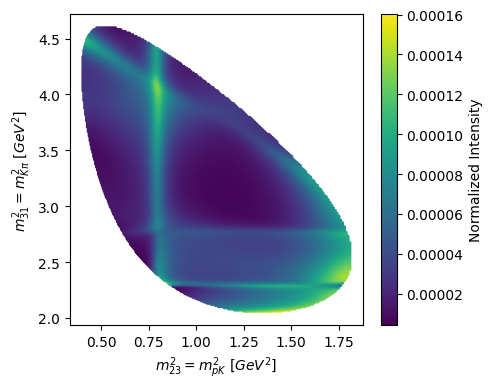

In [9]:
intensity_integral = jnp.nansum(intensity_vals)
norm_density_vals = intensity_vals / intensity_integral

plt.figure(figsize=(5, 4))
plt.scatter(grid[:,0], grid[:,1], c=norm_density_vals, s=2)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Normalized Intensity')
plt.xlabel(r"$m_{23}^2 = m_{pK}^2 ~ [GeV^2]$")
plt.ylabel(r"$m_{31}^2 = m_{K\pi}^2 ~ [GeV^2]$")
plt.tight_layout();

### Test transformation from Dalitz plot to square DP and back

- create grid in Dalitz plot space $[s_{12}, s_{23}]$
- transform to square DP via
$$I(\cos \theta_{12}, s_{23}) = I(s_{12}, s_{23}) \cdot \left| \frac{\partial s_{12}}{\partial \cos \theta_{12}} \right| = I(s_{12}, s_{23}) \cdot \left| \frac{\partial \cos \theta_{12}}{\partial s_{12}} \right|^{-1}$$
- transform square DP back to original DP via
$$I'(s_{12}, s_{23}) = I(\cos \theta_{12}, s_{23}) \cdot \left| \frac{\partial \cos \theta_{12}}{\partial s_{12}} \right| = I(\cos \theta_{12}, s_{23}) \cdot \left| \frac{\partial s_{12}}{\partial \cos \theta_{12}} \right|^{-1}$$


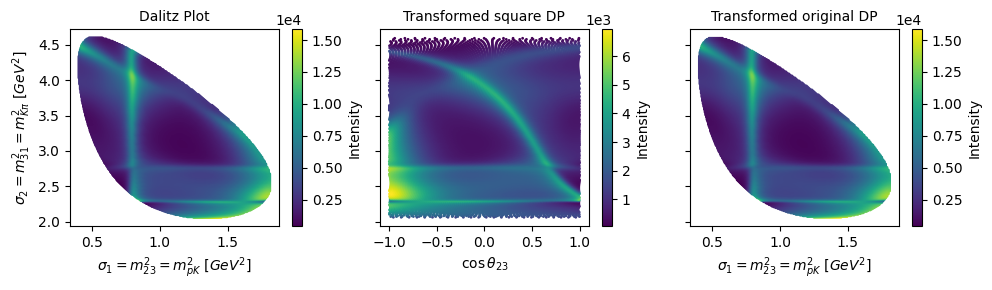

In [10]:
fig, axs = plt.subplots(1,3, sharey=True, figsize=(10, 3))

pcm0 = axs[0].scatter(grid[:,0], grid[:,1], c=intensity_vals, s=2)
cbar = fig.colorbar(pcm0, ax=axs[0])
cbar.ax.set_ylabel('Intensity')
cbar.formatter.set_powerlimits((0, 0))
axs[0].set_xlabel(r"$\sigma_1 = m_{23}^2 = m_{pK}^2 ~ [GeV^2]$")
axs[0].set_ylabel(r"$\sigma_2 = m_{31}^2 = m_{K\pi}^2 ~ [GeV^2]$")
axs[0].set_title("Dalitz Plot", fontsize=10)

grid_square, dcds23 = target.get_cos_theta_from_s23(grid)
square_density_vals = intensity_vals / jnp.abs(dcds23)
pcm1 = axs[1].scatter(grid_square[:,0], grid_square[:,1], c=square_density_vals, s=1.)
cbar = fig.colorbar(pcm1, ax=axs[1])
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.set_ylabel('Intensity')
axs[1].set_xlabel(r"$\cos \theta_{23}$")
axs[1].set_title("Transformed square DP", fontsize=10)

grid_back, ds23dcos = target.get_s23_from_cos_theta(grid_square)
trafo_density_vals = square_density_vals / jnp.abs(ds23dcos)
pcm1 = axs[2].scatter(grid_back[:,0], grid_back[:,1], c=trafo_density_vals, s=1.)
cbar = fig.colorbar(pcm1, ax=axs[2])
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.set_ylabel('Intensity')
axs[2].set_xlabel(r"$\sigma_1 = m_{23}^2 = m_{pK}^2 ~ [GeV^2]$")
axs[2].set_title("Transformed original DP", fontsize=10)
plt.tight_layout();

### Scale original Dalitz plot to square and to unit interval (and other direction)

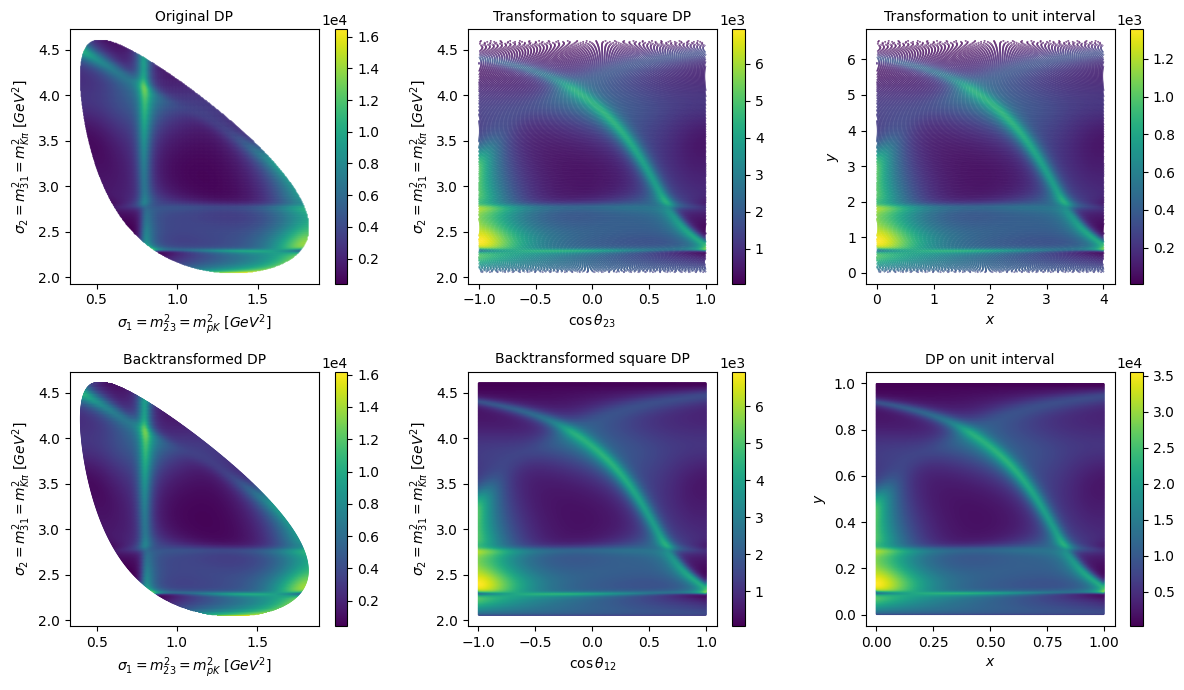

In [11]:
fig, axs = plt.subplots(2,3, figsize=(12,7))

# Original Dalitz plot

# setup grid with axes [s23, s31]
s23vs = jnp.linspace(target.m2 + target.m3, target.m0 - target.m1, 300)[1:-1]**2
s31vs = jnp.linspace(target.m3 + target.m1, target.m0 - target.m2, 302)[1:-1]**2
grid = jnp.dstack(jnp.meshgrid(s23vs, s31vs))
grid = grid.reshape([-1, 2])
I_original = target.get_decay_rate(grid)

pcm0 = axs[0,0].scatter(grid[:,0], grid[:,1], c=I_original, s=.1)
cbar = fig.colorbar(pcm0, ax=axs[0,0])
cbar.formatter.set_powerlimits((0, 0))
axs[0,0].set_xlabel(r"$\sigma_1 = m_{23}^2 = m_{pK}^2 ~ [GeV^2]$")
axs[0,0].set_ylabel(r"$\sigma_2 = m_{31}^2 = m_{K\pi}^2 ~ [GeV^2]$")
axs[0,0].set_title(r"Original DP", fontsize=10)

# Transform to square DP
grid_square, dcds = target.get_cos_theta_from_s23(grid)
I_square_transformed = I_original / jnp.abs(dcds)

pcm1 = axs[0,1].scatter(grid_square[:,0], grid_square[:,1], c=I_square_transformed, s=.1)
cbar = fig.colorbar(pcm1, ax=axs[0,1])
cbar.formatter.set_powerlimits((0, 0))
axs[0,1].set_title(r"Transformation to square DP", fontsize=10)
axs[0,1].set_xlabel(r"$\cos \theta_{23}$")
axs[0,1].set_ylabel(r"$\sigma_2 = m_{31}^2 = m_{K\pi}^2 ~ [GeV^2]$")

# Transform to [0,1]^2 interval
grid_unit, detJ = target.scale_samples_to_unit_interval(grid_square)
dxdcos, dyds31 = detJ[:,0], detJ[:,1]
I_unit = I_square_transformed * jnp.where(dxdcos.any()==0 or dyds31.any()==0, 0, 1/jnp.abs(dxdcos * dyds31))
pcm2 = axs[0,2].scatter(grid_unit[:,0], grid_unit[:,1], c=I_unit, s=.1)
cbar = fig.colorbar(pcm2, ax=axs[0,2])
cbar.formatter.set_powerlimits((0, 0))
axs[0,2].set_title(r"Transformation to unit interval", fontsize=10)
axs[0,2].set_xlabel(r"$x$")
axs[0,2].set_ylabel(r"$y$")


# Unit interval grid
# setup grid with axes [x, y]
x = y = jnp.linspace(0., 1., 300)[1:-1]
grid_unit = jnp.dstack(jnp.meshgrid(x, y))
grid_unit = grid_unit.reshape([-1, 2])

# transform back to square DP
grid_square, detJ = target.scale_samples_to_original_interval(grid_unit)
dcosdx, ds31dy = detJ[:,0], detJ[:,1]

# transform back to DP
dp_grid, ds23dcos = target.get_s23_from_cos_theta(grid_square)
I_dp = target.get_decay_rate(dp_grid)
I_square = I_dp * jnp.abs(ds23dcos)
I_unit = I_square * jnp.abs(dcosdx) * jnp.abs(ds31dy)
I_dp_no_nan = jnp.nan_to_num(I_dp, nan=-1)
I_square_no_nan = jnp.nan_to_num(I_square, nan=-1)
I_unit_no_nan = jnp.nan_to_num(I_unit, nan=-1)

# Plot backtransformed original DP
pcm2 = axs[1,0].scatter(dp_grid[:,0], dp_grid[:,1], c=I_dp_no_nan, s=.5)
cbar = fig.colorbar(pcm2, ax=axs[1,0])
cbar.formatter.set_powerlimits((0, 0))
axs[1,0].set_title(r"Backtransformed DP", fontsize=10)
axs[1,0].set_xlabel(r"$\sigma_1 = m_{23}^2 = m_{pK}^2 ~ [GeV^2]$")
axs[1,0].set_ylabel(r"$\sigma_2 = m_{31}^2 = m_{K\pi}^2 ~ [GeV^2]$")

# Plot backtransformed square DP
pcm1 = axs[1,1].scatter(grid_square[:,0], grid_square[:,1], c=I_square_no_nan, s=.5)
cbar = fig.colorbar(pcm1, ax=axs[1,1])
cbar.formatter.set_powerlimits((0, 0))
axs[1,1].set_title(r"Backtransformed square DP", fontsize=10)
axs[1,1].set_xlabel(r"$\cos \theta_{12}$")
axs[1,1].set_ylabel(r"$\sigma_2 = m_{31}^2 = m_{K\pi}^2 ~ [GeV^2]$")

# Plot init interval DP
pcm3 = axs[1,2].scatter(grid_unit[:,0], grid_unit[:,1], c=I_unit_no_nan, s=.5)
cbar = fig.colorbar(pcm3, ax=axs[1,2])
cbar.formatter.set_powerlimits((0, 0))
axs[1,2].set_title(r"DP on unit interval", fontsize=10)
axs[1,2].set_xlabel(r"$x$")
axs[1,2].set_ylabel(r"$y$")
axs[1,2].set_ylim([-0.05, 1.05])

plt.tight_layout();

### Test transformation functions which are important for flow training
- input: samples from flow $(x, y)$
- transform samples: $(x, y) \rightarrow (\cos \theta_{23}, s_{31}) \rightarrow (s_{23}, s_{31})$
- evaluate $I(s_{23}, s_{31}) = \tilde{p}(s_{23}, s_{31})$
- transform $\tilde{p}(s_{23}, s_{31})$ to $\tilde{p}(x, y)$ via
$$\tilde{p}(x, y)  = I(x,y) = I(s_{23}, s_{31})\cdot \left| \frac{\partial s_{23}}{\partial \cos \theta_{23}} \right| \cdot \left| \frac{\partial \cos \theta_{23}}{\partial x} \right| \cdot \left| \frac{\partial s_{31}}{\partial y} \right|$$

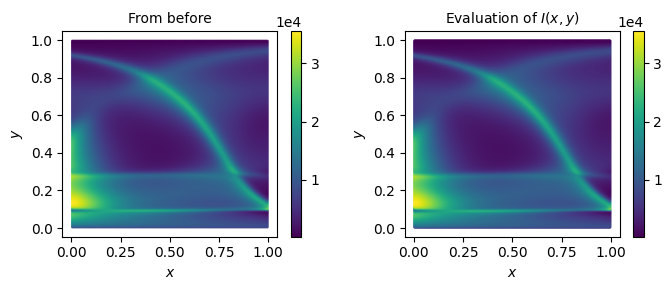

In [12]:
I_pred_grid = target.evaluate_DP_on_unit_interval(grid_unit)
fig, axs = plt.subplots(1,2, figsize=(7, 3))
pcm0 = axs[0].scatter(grid_unit[:,0], grid_unit[:,1], c=I_unit_no_nan, s=.1)
cbar = fig.colorbar(pcm0, ax=axs[0])
cbar.formatter.set_powerlimits((0, 0))
axs[0].set_xlabel(r"$x$")
axs[0].set_ylabel(r"$y$")
axs[0].set_title("From before", fontsize=10)

pcm1 = axs[1].scatter(grid_unit[:,0], grid_unit[:,1], c=I_pred_grid, s=.5)
cbar = fig.colorbar(pcm1, ax=axs[1])
cbar.formatter.set_powerlimits((0, 0))
axs[1].set_xlabel(r"$x$")
axs[1].set_ylabel(r"$y$")
axs[1].set_title("Evaluation of $I(x, y)$", fontsize=10)

plt.tight_layout();

### Visualize Jacobian determinant in DP space
- samples from flow $(x, y)$
- transform samples: $(x, y) \rightarrow (\cos \theta_{23}, s_{31}) \rightarrow (s_{23}, s_{31})$
- plot $\det J$ for all $(s_{23}, s_{31})$
- visualize non-exploding transformation of linear dummy distribution

min max of detJ 0.19542404316725842 3.021451454946386
sample with min detJ [0.00334448 0.99665552] dsdcos value of min -0.03818878025844765
max of 1/detJ 5.11707763176369


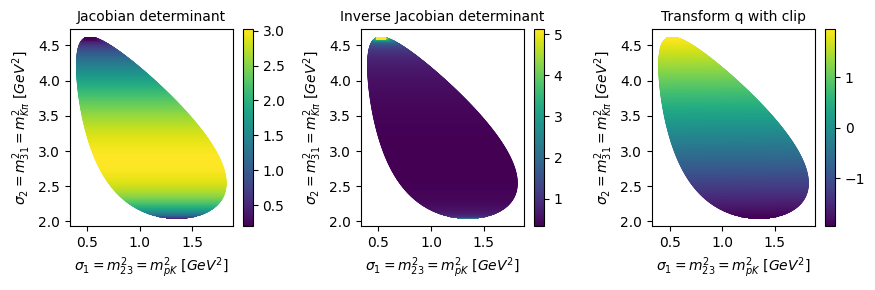

In [13]:
samples_square_dp, detJ = target.scale_samples_to_original_interval(grid_unit)
dcosdx, dsdy = detJ[:, 0], detJ[:, 1]
samples_dp, dsdcos = target.get_s23_from_cos_theta(samples_square_dp)
grid_detJ = jnp.abs(dsdcos) * jnp.abs(dcosdx) * jnp.abs(dsdy)
print("min max of detJ", jnp.nanmin(grid_detJ), jnp.nanmax(grid_detJ))
ind_min = jnp.argmin(grid_detJ)
print("sample with min detJ", grid_unit[ind_min,:], "dsdcos value of min", dsdcos[ind_min])
print("max of 1/detJ", jnp.max(1/grid_detJ))

fig, axs = plt.subplots(1,3, figsize=(9,3))
pcm0 = axs[0].scatter(samples_dp[:,0], samples_dp[:,1], c=grid_detJ, s=.5)
cbar = fig.colorbar(pcm0, ax=axs[0])
axs[0].set_xlabel(r"$\sigma_1 = m_{23}^2 = m_{pK}^2 ~ [GeV^2]$")
axs[0].set_ylabel(r"$\sigma_2 = m_{31}^2 = m_{K\pi}^2 ~ [GeV^2]$")
axs[0].set_title("Jacobian determinant", fontsize=10)

pcm1 = axs[1].scatter(samples_dp[:,0], samples_dp[:,1], c=1/grid_detJ, s=.5)
cbar = fig.colorbar(pcm1, ax=axs[1])
axs[1].set_xlabel(r"$\sigma_1 = m_{23}^2 = m_{pK}^2 ~ [GeV^2]$")
axs[1].set_ylabel(r"$\sigma_2 = m_{31}^2 = m_{K\pi}^2 ~ [GeV^2]$")
axs[1].set_title("Inverse Jacobian determinant", fontsize=10)

# Why does the multivariate normal return Nan???
q_flow_dummy = jnp.linspace(-1, 1, len(dcosdx))
samples_dp, q_dp = target.transform_q_to_physical_space(grid_unit, q_flow_dummy)
pcm2 = axs[2].scatter(samples_dp[:,0], samples_dp[:,1], c=q_dp, s=.5)
cbar = fig.colorbar(pcm2, ax=axs[2])
axs[2].set_xlabel(r"$\sigma_1 = m_{23}^2 = m_{pK}^2 ~ [GeV^2]$")
axs[2].set_ylabel(r"$\sigma_2 = m_{31}^2 = m_{K\pi}^2 ~ [GeV^2]$")
axs[2].set_title("Transform q with clip", fontsize=10)

plt.tight_layout();

### Test `log_prob`

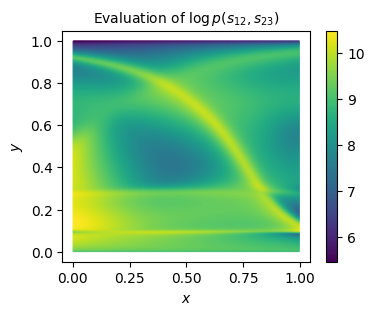

In [14]:
# Unit interval grid
# setup grid with axes [x, y]
x = y = jnp.linspace(0., 1., 300)[1:-1]
grid_unit = jnp.dstack(jnp.meshgrid(x, y))
grid_unit = grid_unit.reshape([-1, 2])

log_probs = target.log_prob(grid_unit)
fig, axs = plt.subplots(1,1, figsize=(4, 3))
pcm0 = axs.scatter(grid_unit[:,0], grid_unit[:,1], c=log_probs, s=.1)
fig.colorbar(pcm0, ax=axs)
axs.set_xlabel(r"$x$")
axs.set_ylabel(r"$y$")
axs.set_title(r"Evaluation of $\log p(s_{12}, s_{23})$", fontsize=10);